In [1]:
# from numba import jit
# from tqdm import trange
# import pandas as pd
# eo_df = pd.read_csv("/mnt/sda1/cvpr21/Classification/Aerial-View-Object-Classification/data/train_EO.csv")
# eo_df = eo_df.sort_values(by='img_name')

# sar_df = pd.read_csv("/mnt/sda1/cvpr21/Classification/Aerial-View-Object-Classification/data/train_SAR.csv") 
# sar_df = sar_df.sort_values(by='img_name')

# @jit()
# def equal():
#     notsame_image = 0
#     notsame_label = 0
#     t = trange(len(sar_df))
    

    
#     for i in t:
#         t.set_postfix({'nums of not same label:': notsame_label})
#         eo_label = next(eo_df.iterrows())[1].class_id
#         sar_label = next(sar_df.iterrows())[1].class_id
#     #     if not eo_image == sar_image:
#     #         notsame_image += 1
#         if not eo_label == sar_label:
#             notsame_label += 1
# #         notsame_label += 1
# #     print("nums of not same imageid:", notsame_image)
#         #print("nums of not same label:", notsame_label)

# equal()

    

In [2]:
from __future__ import print_function, division

import torch
import math
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.autograd import Variable
import random
import torch.nn.functional as F

exp_num = "45_kd_sar-teacher_eo-student_pretrain-on-sar"


In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
#     tf.set_random_seed(seed)

seed = 2019
seed_everything(seed)

In [4]:
#https://github.com/4uiiurz1/pytorch-auto-augment

import random
import numpy as np
import scipy
from scipy import ndimage
from PIL import Image, ImageEnhance, ImageOps


class AutoAugment(object):
    def __init__(self):
        self.policies = [
            ['Invert', 0.1, 7, 'Contrast', 0.2, 6],
            ['Rotate', 0.7, 2, 'TranslateX', 0.3, 9],
            ['Sharpness', 0.8, 1, 'Sharpness', 0.9, 3],
            ['ShearY', 0.5, 8, 'TranslateY', 0.7, 9],
            ['AutoContrast', 0.5, 8, 'Equalize', 0.9, 2],
            ['ShearY', 0.2, 7, 'Posterize', 0.3, 7],
            ['Color', 0.4, 3, 'Brightness', 0.6, 7],
            ['Sharpness', 0.3, 9, 'Brightness', 0.7, 9],
            ['Equalize', 0.6, 5, 'Equalize', 0.5, 1],
            ['Contrast', 0.6, 7, 'Sharpness', 0.6, 5],
            ['Color', 0.7, 7, 'TranslateX', 0.5, 8],
            ['Equalize', 0.3, 7, 'AutoContrast', 0.4, 8],
            ['TranslateY', 0.4, 3, 'Sharpness', 0.2, 6],
            ['Brightness', 0.9, 6, 'Color', 0.2, 8],
            ['Solarize', 0.5, 2, 'Invert', 0.0, 3],
            ['Equalize', 0.2, 0, 'AutoContrast', 0.6, 0],
            ['Equalize', 0.2, 8, 'Equalize', 0.6, 4],
            ['Color', 0.9, 9, 'Equalize', 0.6, 6],
            ['AutoContrast', 0.8, 4, 'Solarize', 0.2, 8],
            ['Brightness', 0.1, 3, 'Color', 0.7, 0],
            ['Solarize', 0.4, 5, 'AutoContrast', 0.9, 3],
            ['TranslateY', 0.9, 9, 'TranslateY', 0.7, 9],
            ['AutoContrast', 0.9, 2, 'Solarize', 0.8, 3],
            ['Equalize', 0.8, 8, 'Invert', 0.1, 3],
            ['TranslateY', 0.7, 9, 'AutoContrast', 0.9, 1],
        ]

    def __call__(self, img):
        img = apply_policy(img, self.policies[random.randrange(len(self.policies))])
        return img


operations = {
    'ShearX': lambda img, magnitude: shear_x(img, magnitude),
    'ShearY': lambda img, magnitude: shear_y(img, magnitude),
    'TranslateX': lambda img, magnitude: translate_x(img, magnitude),
    'TranslateY': lambda img, magnitude: translate_y(img, magnitude),
    'Rotate': lambda img, magnitude: rotate(img, magnitude),
    'AutoContrast': lambda img, magnitude: auto_contrast(img, magnitude),
    'Invert': lambda img, magnitude: invert(img, magnitude),
    'Equalize': lambda img, magnitude: equalize(img, magnitude),
    'Solarize': lambda img, magnitude: solarize(img, magnitude),
    'Posterize': lambda img, magnitude: posterize(img, magnitude),
    'Contrast': lambda img, magnitude: contrast(img, magnitude),
    'Color': lambda img, magnitude: color(img, magnitude),
    'Brightness': lambda img, magnitude: brightness(img, magnitude),
    'Sharpness': lambda img, magnitude: sharpness(img, magnitude),
    'Cutout': lambda img, magnitude: cutout(img, magnitude),
}


def apply_policy(img, policy):
    if random.random() < policy[1]:
        img = operations[policy[0]](img, policy[2])
    if random.random() < policy[4]:
        img = operations[policy[3]](img, policy[5])

    return img


def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = offset_matrix @ matrix @ reset_matrix
    return transform_matrix


def shear_x(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-0.3, 0.3, 11)

    transform_matrix = np.array([[1, random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]), 0],
                                 [0, 1, 0],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img


def shear_y(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-0.3, 0.3, 11)

    transform_matrix = np.array([[1, 0, 0],
                                 [random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]), 1, 0],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img


def translate_x(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-150/331, 150/331, 11)

    transform_matrix = np.array([[1, 0, 0],
                                 [0, 1, img.shape[1]*random.uniform(magnitudes[magnitude], magnitudes[magnitude+1])],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img


def translate_y(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-150/331, 150/331, 11)

    transform_matrix = np.array([[1, 0, img.shape[0]*random.uniform(magnitudes[magnitude], magnitudes[magnitude+1])],
                                 [0, 1, 0],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img


def rotate(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-30, 30, 11)
    theta = np.deg2rad(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    transform_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                 [np.sin(theta), np.cos(theta), 0],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img


def auto_contrast(img, magnitude):
    img = ImageOps.autocontrast(img)
    return img


def invert(img, magnitude):
    img = ImageOps.invert(img)
    return img


def equalize(img, magnitude):
    img = ImageOps.equalize(img)
    return img


def solarize(img, magnitude):
    magnitudes = np.linspace(0, 256, 11)
    img = ImageOps.solarize(img, random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def posterize(img, magnitude):
    magnitudes = np.linspace(4, 8, 11)
    img = ImageOps.posterize(img, int(round(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))))
    return img


def contrast(img, magnitude):
    magnitudes = np.linspace(0.1, 1.9, 11)
    img = ImageEnhance.Contrast(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def color(img, magnitude):
    magnitudes = np.linspace(0.1, 1.9, 11)
    img = ImageEnhance.Color(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def brightness(img, magnitude):
    magnitudes = np.linspace(0.1, 1.9, 11)
    img = ImageEnhance.Brightness(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def sharpness(img, magnitude):
    magnitudes = np.linspace(0.1, 1.9, 11)
    img = ImageEnhance.Sharpness(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def cutout(org_img, magnitude=None):
    img = np.array(img)

    magnitudes = np.linspace(0, 60/331, 11)

    img = np.copy(org_img)
    mask_val = img.mean()

    if magnitude is None:
        mask_size = 16
    else:
        mask_size = int(round(img.shape[0]*random.uniform(magnitudes[magnitude], magnitudes[magnitude+1])))
    top = np.random.randint(0 - mask_size//2, img.shape[0] - mask_size)
    left = np.random.randint(0 - mask_size//2, img.shape[1] - mask_size)
    bottom = top + mask_size
    right = left + mask_size

    if top < 0:
        top = 0
    if left < 0:
        left = 0

    img[top:bottom, left:right, :].fill(mask_val)

    img = Image.fromarray(img)

    return img



class Cutout(object):
    def __init__(self, length=16):
        self.length = length

    def __call__(self, img):
        img = np.array(img)

        mask_val = img.mean()

        top = np.random.randint(0 - self.length//2, img.shape[0] - self.length)
        left = np.random.randint(0 - self.length//2, img.shape[1] - self.length)
        bottom = top + self.length
        right = left + self.length

        top = 0 if top < 0 else top
        left = 0 if left < 0 else top

        img[top:bottom, left:right, :] = mask_val

        img = Image.fromarray(img)

        return img

### MIXUP

In [5]:
alpha_ = 0.4


# def mixup_data(x, y, alpha=alpha_, use_cuda=True):
#     if alpha > 0:
#         lam = np.random.beta(alpha, alpha)
#     else:
#         lam = 1

#     batch_size = x.size()[0]
#     if use_cuda:
#         index = torch.randperm(batch_size).cuda()
#     else:
#         index = torch.randperm(batch_size)

#     mixed_x = lam * x + (1 - lam) * x[index, :]
#     y_a, y_b = y, y[index]
#     return mixed_x, y_a, y_b, lam

# def mixup_criterion(criterion, pred, y_a, y_b, lam):
#     return lam * criterion(pred.float().cuda(), y_a.float().cuda()) + (1 - lam) * criterion(pred.float().cuda(), y_b.float().cuda())


def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
#     print(y)
    y_a, y_b = y, y[index]
    
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [6]:
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

In [7]:


plt.ion()   # interactive mode

EO_data_transforms = {
    'Training': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((30,30)),
        AutoAugment(),
        Cutout(),
#         transforms.RandomRotation(15,),
#         transforms.RandomResizedCrop(30),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.2913437], [0.12694514])
        
        
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        #transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'Test': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(30),
        transforms.ToTensor(),
        transforms.Normalize([0.2913437], [0.12694514])
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
       # transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid_EO': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((30,30)),
#         AutoAugment(),
        
#         transforms.RandomRotation(15,),
#         transforms.RandomResizedCrop(48),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.2913437], [0.12694514])
        
#         transforms.Grayscale(num_output_channels=1),
#         transforms.Resize(48),
#         transforms.ToTensor(),
#         transforms.Normalize([0.5], [0.5])
#         transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
       # transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}



# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'Training': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((52,52)),
        transforms.RandomRotation(15,),
        transforms.RandomResizedCrop(48),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.4062625], [0.12694514])
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        #transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'Test': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(48),
        transforms.ToTensor(),
        transforms.Normalize([0.4062625], [0.12694514])
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
       # transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((52,52)),
        transforms.RandomRotation(15,),
        transforms.RandomResizedCrop(48),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.4062625], [0.12694514])
        
#         transforms.Grayscale(num_output_channels=1),
#         transforms.Resize(48),
#         transforms.ToTensor(),
#         transforms.Normalize([0.5], [0.5])
#         transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
       # transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}


# data_dir = '/mnt/sda1/cvpr21/Classification/ram'
# EO_image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           EO_data_transforms[x])
#                   for x in ['Training', 'Test']}
# EO_dataloaders = {x: torch.utils.data.DataLoader(EO_image_datasets[x], batch_size=256,
#                                              shuffle=True, num_workers=64, pin_memory=True)
#               for x in ['Training', 'Test']}
# EO_dataset_sizes = {x: len(EO_image_datasets[x]) for x in ['Training', 'Test']}
# EO_class_names = EO_image_datasets['Training'].classes



# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['Training', 'Test']}

# combine_dataset = ConcatDataset(EO_image_datasets, image_datasets)
# dataloaders = {x: torch.utils.data.DataLoader(combine_dataset[x], batch_size=256,
#                                              shuffle=True, num_workers=64, pin_memory=True)
#               for x in ['Training', 'Test']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Test']}
# class_names = image_datasets['Training'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# def imshow(inp, title=None):
#     """Imshow for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
# #     mean = np.array([0.1786, 0.4739, 0.5329])
# #     std = np.array([[0.0632, 0.1361, 0.0606]])
# #     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated


    
# # Get a batch of training data
# EO_inputs, EO_classes = next(iter(EO_dataloaders['Training']))


# inputs, classes, k ,_= next(iter(dataloaders))






# # Make a grid from batch
# EO_out = torchvision.utils.make_grid(EO_inputs)

# out = torchvision.utils.make_grid(inputs)
# imshow(EO_out, title=[EO_class_names[x] for x in classes])

# imshow(out, title=[class_names[x] for x in classes])

In [8]:
from torch.utils import data
from tqdm import tqdm
from PIL import Image
output_dim = 10

class SAR_EO_Combine_Dataset(data.Dataset):
    def __init__(self,df_sar,dirpath_sar,transform_sar,df_eo=None,dirpath_eo=None,transform_eo=None,test = False):
        self.df_sar = df_sar
        self.test = test
        self.dirpath_sar = dirpath_sar
        self.transform_sar = transform_sar
        
        self.df_eo = df_eo
#         self.test = test
        self.dirpath_eo = dirpath_eo
        self.transform_eo = transform_eo
        #image data 
#         if not self.test:
#             self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0]+'.png')
#         else:
#             self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0])
        
#         #labels data
#         if not self.test:
#              self.label_df = self.df.iloc[:,1]
        
        # Calculate length of df
        self.data_len = len(self.df_sar.index)

    def __len__(self):
        return self.data_len
    
    
    def __getitem__(self, idx):
        image_name_sar = self.df_sar.img_name[idx]
        image_name_sar = os.path.join(self.dirpath_sar, image_name_sar)
        img_sar = Image.open(image_name_sar)#.convert('RGB')
        img_tensor_sar = self.transform_sar(img_sar)
        
        image_name_eo = self.df_eo.img_name[idx]
        image_name_eo = os.path.join(self.dirpath_eo, image_name_eo)
        img_eo = Image.open(image_name_eo)#.convert('RGB')
        img_tensor_eo = self.transform_eo(img_eo)
        
#         image_name = self.df.img_name[idx]
#         img = Image.open(image_name)#.convert('RGB')
#         img_tensor = self.transform(img)
        
        
        if not self.test:
            image_labels = int(self.df_sar.class_id[idx])
#             label_tensor = torch.zeros((1, output_dim))
#             for label in image_labels.split():
#                 label_tensor[0, int(label)] = 1
            image_label = torch.tensor(image_labels,dtype= torch.long)
            image_label = image_label.squeeze()
            
            image_labels_eo = int(self.df_eo.class_id[idx])
#             label_tensor_eo = torch.zeros((1, output_dim))
#             for label_eo in image_labels_eo.split():
#                 label_tensor_eo[0, int(label_eo)] = 1
            image_label_eo = torch.tensor(image_labels_eo,dtype= torch.long)
            image_label_eo = image_label_eo.squeeze()
#             print(image_label_eo)
            
            
            
            
            return (img_tensor_sar,image_label), (img_tensor_eo, image_label_eo)
        
        return (img_tensor_sar)


In [9]:
class SAR_EO_Combine_Dataset2(data.Dataset):
    def __init__(self,df_sar,dirpath_sar,transform_sar,df_eo=None,dirpath_eo=None,transform_eo=None,test = False):
        self.df_sar = df_sar
        self.test = test
        self.dirpath_sar = dirpath_sar
        self.transform_sar = transform_sar
        
        self.df_eo = df_eo
#         self.test = test
        self.dirpath_eo = dirpath_eo
        self.transform_eo = transform_eo
        #image data 
#         if not self.test:
#             self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0]+'.png')
#         else:
#             self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0])
        
#         #labels data
#         if not self.test:
#              self.label_df = self.df.iloc[:,1]
        
        # Calculate length of df
        self.data_len = len(self.df_sar.index)

    def __len__(self):
        return self.data_len
    
    
    def __getitem__(self, idx):
        image_name_sar = self.df_sar.img_name[idx]
        image_name_sar = os.path.join(self.dirpath_sar, image_name_sar)
        img_sar = Image.open(image_name_sar)#.convert('RGB')
        img_tensor_sar = self.transform_sar(img_sar)
        
        image_name_eo = self.df_eo.img_name[idx]
        image_name_eo = os.path.join(self.dirpath_eo, image_name_eo)
        img_eo = Image.open(image_name_eo)#.convert('RGB')
        img_tensor_eo = self.transform_eo(img_eo)
        
#         image_name = self.df.img_name[idx]
#         img = Image.open(image_name)#.convert('RGB')
#         img_tensor = self.transform(img)
        
        
        if not self.test:
            image_labels = int(self.df_sar.class_id[idx])
#             label_tensor = torch.zeros((1, output_dim))
#             for label in image_labels.split():
#                 label_tensor[0, int(label)] = 1
            image_label = torch.tensor(image_labels,dtype= torch.long)
            image_label = image_label.squeeze()
            
            image_labels_eo = int(self.df_eo.class_id[idx])
#             label_tensor_eo = torch.zeros((1, output_dim))
#             for label_eo in image_labels_eo.split():
#                 label_tensor_eo[0, int(label_eo)] = 1
            image_label_eo = torch.tensor(image_labels_eo,dtype= torch.long)
            image_label_eo = image_label_eo.squeeze()
#             print(image_label_eo)
            
            
            
            
            return (img_tensor_sar,image_label), (img_tensor_eo, image_label_eo)
        
        return (img_tensor_sar)

In [14]:
import pandas as pd
eo_df = pd.read_csv("/home/hans/sandisk/dataset_mover/kd_train_EO.csv")
eo_df = eo_df.sort_values(by='img_name')

sar_df = pd.read_csv("/home/hans/sandisk/dataset_mover/kd_train_SAR.csv") 
sar_df = sar_df.sort_values(by='img_name')

In [15]:



eo_test_df = pd.read_csv("/home/hans/sandisk/dataset_mover/kd_test_EO.csv")
eo_test_df = eo_test_df.sort_values(by='img_name')

sar_test_df = pd.read_csv("/home/hans/sandisk/dataset_mover/kd_test_SAR.csv") 
sar_test_df = sar_test_df.sort_values(by='img_name')

In [16]:
BATCH_SIZE = 512

dirpath_sar = "/home/hans/sandisk/dataset_mover/kd_train_SAR"
dirpath_eo = "/home/hans/sandisk/dataset_mover/kd_train_EO"
SAR_EO_Combine = SAR_EO_Combine_Dataset(sar_df,dirpath_sar,data_transforms["Test"],eo_df,dirpath_eo,EO_data_transforms["Training"],test = False)


In [17]:



testpath_sar = "/home/hans/sandisk/dataset_mover/kd_val_SAR"
testpath_eo = "/home/hans/sandisk/dataset_mover/kd_val_EO"

test_set = SAR_EO_Combine_Dataset(sar_test_df,testpath_sar,data_transforms["Test"],eo_test_df,testpath_eo,EO_data_transforms["Test"],test = False)
# test_loader = data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [19]:
train_size = len(SAR_EO_Combine)

In [20]:

test_size = len(test_set)

# from sklearn.model_selection import train_test_split

# train_dataset, test_dataset = train_test_split(SAR_EO_Combine[0], SAR_EO_Combine[2], test_size=0.2, random_state=2017, stratify = SAR_EO_Combine[2])
# train_dataset, test_dataset = torch.utils.data.random_split(SAR_EO_Combine, [train_size, test_size])

In [21]:
data_loader = data.DataLoader(dataset=SAR_EO_Combine,batch_size=BATCH_SIZE,shuffle=True,pin_memory = True)

In [22]:

test_loader = data.DataLoader(dataset=test_set,batch_size=BATCH_SIZE,shuffle=True,pin_memory = True)

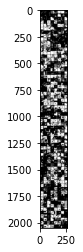

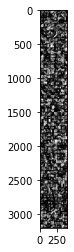

512
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 0, 3, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0,
        4, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 3, 0,
        3, 0, 0, 2, 4, 1, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 3, 0,
        0, 0, 0, 3, 1, 2, 3, 0, 0, 3, 0, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2,
        0, 3, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2,
        2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 1, 0, 1, 1, 0, 1, 1, 0, 0, 3, 0, 0, 3,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2,
        1, 0, 3, 0, 0, 0, 0, 0, 0, 0

In [23]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.1786, 0.4739, 0.5329])
#     std = np.array([[0.0632, 0.1361, 0.0606]])
#     inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


SAR, EO = next(iter(data_loader))
# Get a batch of training data
EO_inputs, EO_classes = EO[0],EO[1]


inputs, classes = SAR[0],SAR[1]


# EO_class_names = SAR_EO_Combine.image_label



# Make a grid from batch
EO_out = torchvision.utils.make_grid(EO_inputs)

out = torchvision.utils.make_grid(inputs)
imshow(EO_out)#, title=[EO_class_names[x] for x in classes])

imshow(out)#, title=[class_names[x] for x in classes])
print(len(EO_classes))
print(classes)

In [24]:
# a = 0
# for i in range(500):
#     SAR, EO = next(iter(data_loader))
# # Get a batch of training data
#     EO_inputs, EO_classes = EO[0],EO[1]


#     inputs, classes = SAR[0],SAR[1]
#     if 9 in classes:
#         a+=1
#     print(a)

### check if paired succeed

In [25]:
# from tqdm import trange
# def equal():
#     notsame_image = 0
#     notsame_label = 0
#     t = trange(len(sar_df))
    

    
#     for i in t:
#         t.set_postfix({'nums of not same label:': notsame_label})
#         sar, eo = next(iter(data_loader))
#         eo_label = eo[1][0].tolist()
#         sar_label = sar[1][0].tolist()
# #         print(eo_label)
# #         print(sar_label)
#     #     if not eo_image == sar_image:
#     #         notsame_image += 1
        
# #             eoval = next(eo_label) 
# #             sarval = next(sar_label) 
#         if not eo_label==sar_label:
#             notsame_label += 1
        
# #         notsame_label += 1
# #     print("nums of not same imageid:", notsame_image)
#         #print("nums of not same label:", notsame_label)

# equal()
# #next(iter(data_loader))

In [26]:
len(sar_df) == len(eo_df)

True

In [27]:
next(eo_df.iterrows())[1]

img_name    EO_0.png
class_id           0
Name: 0, dtype: object

In [28]:
Num_class=10
num_classes = Num_class
num_channel = 1

# model_ft = models.resnet34(pretrained=False)
model_ft = torch.load("10/pre_resnet34_model_epoch99.pt") ## Attention: you need to change to the path of pre_EO.pt file, which located in the repo folder pre-train
# model_ft.conv1 = nn.Conv2d(num_channel, 64, kernel_size=7, stride=2, padding=3,bias=False)
# # model_ft.avgpool = SpatialPyramidPooling((3,3))
# model_ft.fc = nn.Linear(512, Num_class)
# model_ft.conv0 = nn.Conv2d(
# model_ft.features[0] = nn.Conv2d(num_channel, 16, kernel_size=3, stride=2, padding=1,bias=False)
# model_ft.classifier[3] = nn.Linear(1024, Num_class, bias=True)
model_ft.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
data_dir = '/mnt/sda1/cvpr21/Classification/ram'
weights = []
for i in range(len(os.listdir(os.path.join(data_dir, "Training")))):
    img_num = len([lists for lists in os.listdir(os.path.join(data_dir, "Training",str(i)))])
    print('filenum:',len([lists for lists in os.listdir(os.path.join(data_dir, "Training",str(i)))]))# if os.path.isfile(os.path.join(data_dir, lists))]))
    weights.append(img_num)
print(weights)
weights = torch.tensor(weights, dtype=torch.float32).cuda()
weights = weights / weights.sum()
print(weights)
weights = 1.0 / weights
weights = weights / weights.sum()
print(weights)

filenum: 234135
filenum: 28030
filenum: 15234
filenum: 10587
filenum: 1668
filenum: 782
filenum: 768
filenum: 562
filenum: 783
filenum: 573
[234135, 28030, 15234, 10587, 1668, 782, 768, 562, 783, 573]
tensor([0.7988, 0.0956, 0.0520, 0.0361, 0.0057, 0.0027, 0.0026, 0.0019, 0.0027,
        0.0020], device='cuda:0')
tensor([0.0005, 0.0044, 0.0080, 0.0115, 0.0733, 0.1563, 0.1591, 0.2175, 0.1561,
        0.2133], device='cuda:0')


### Teacher model (SAR)

In [30]:
netT = torch.load("10/resnet34_model_epoch119.pt") ## Attention: you need to change to the path of pre_SAR.pt file, which located in the repo folder pre-train

# netT = torch.load('29_auto_aug_eo_sar_noimagenet/pre_resnet34_eo_epoch99.pt')
criterion2 = nn.KLDivLoss()
netT.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
from tqdm.notebook import trange
from tqdm import tqdm_notebook as tqdm 
import warnings
warnings.filterwarnings('ignore')
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    print("---------------Start KD FIT( TEACHER AND STUDENT )-----------------")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_train_acc = 0.0
    
    kd_alpha = 0.2
    
    Loss_list = []
    Accuracy_list = []
    T_Loss_list = []
    T_Accuracy_list = []

    for epoch in trange(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
 
        # Each epoch has a training and validation phase
        for phase in ['Training', 'Test']:#['Test','Training']: #:
            if phase == 'Training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            


            # Iterate over data.
            
            
            if phase == 'Training':
            
                for SAR, EO in tqdm(data_loader):
                    inputs, labels = EO[0], EO[1]
                    inputs = inputs.to(device)

                    labels = labels.to(device)

                    T_input, T_labels = SAR[0], SAR[1]
                    T_input = T_input.to(device)
                    T_labels = T_labels.to(device)
        #                 print(T_labels, labels)
        #                 labels = torch.argmax(labels, 0)
        #                 T_labels = torch.argmax(T_labels, 0)

#                     confusion_matrix = torch.zeros(10, 10)
            
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.no_grad():
                        soft_target = netT(T_input)
                    with torch.set_grad_enabled(phase == 'Training'):
                        outputs = model(inputs) # _, 
                        #print(outputs.dim())

                        _, preds = torch.max(outputs, 1)

#                         for t, p in zip(labels.view(-1), preds.view(-1)):
#                             confusion_matrix[t.long(), p.long()] += 1
#                         print(confusion_matrix.diag()/confusion_matrix.sum(1))
                        
        #                     _, T_preds = torch.max(soft_target, 1)
                        T = 2
                        outputs_S = F.log_softmax(outputs/T, dim=1)
                        outputs_T = F.softmax(soft_target/T, dim=1)
        #                     print(outputs_S.size())
        #                     print(outputs_T.size())

                        loss2 = criterion2(outputs_S, outputs_T) * T * T
                        #print(preds)

                        if phase == 'Training':
                            inputs, y_a, y_b, lam = mixup_data(inputs, labels)
                            inputs, y_a, y_b = map(Variable, (inputs, y_a, y_b))
        #                         print(y_a)
        #                         print(y_b)

                            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
                            loss = loss*(1-kd_alpha) + loss2*kd_alpha
                        else:

                            loss = criterion(outputs, labels)
                            loss = loss*(1-kd_alpha) + loss2*kd_alpha

                        # backward + optimize only if in training phase
                        if phase == 'Training':
                            loss.backward()
                            optimizer.step()


                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'Training':
                    scheduler.step()

                epoch_loss = running_loss / train_size
                epoch_acc = running_corrects.double() / train_size

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

                if phase == "Training":
                    Loss_list.append(epoch_loss)
                    Accuracy_list.append(100 * epoch_acc)
                else:
                    T_Loss_list.append(epoch_loss)
                    T_Accuracy_list.append(100 * epoch_acc)



                # deep copy the model
                if phase == 'Test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    PATH = os.path.join(str(exp_num), "resnet34_kd_best.pt")#"resnet18_model_epoch{}.pt".format(epoch)
                    if not os.path.exists(str(exp_num)):
                        os.makedirs(str(exp_num))
                    torch.save(model, PATH)
                    time_elapsed = time.time() - since
                    print('Time from Start {:.0f}m {:.0f}s'.format(
                        time_elapsed // 60, time_elapsed % 60))

                if phase == 'Training' and epoch_acc > best_train_acc:
                    best_train_acc = epoch_acc
    #                 PATH = os.path.join(str(exp_num), "resnet34_kd_best.pt")#"resnet18_model_epoch{}.pt".format(epoch)
    #                 if not os.path.exists(str(exp_num)):
    #                     os.makedirs(str(exp_num))
    #                 torch.save(model, PATH)
    
    
    #############################################################################
            elif phase == 'Test':
                acc_matrix_sum = torch.zeros(10)
                
                for SAR, EO in tqdm(test_loader):
                    inputs, labels = EO[0], EO[1]
                    inputs = inputs.to(device)
#                     print(inputs)

                    labels = labels.to(device)

                    T_input, T_labels = SAR[0], SAR[1]
                    T_input = T_input.to(device)
                    T_labels = T_labels.to(device)
        #                 print(T_labels, labels)
        #                 labels = torch.argmax(labels, 0)
        #                 T_labels = torch.argmax(T_labels, 0)


                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.no_grad():
                        soft_target = netT(T_input)
                    with torch.set_grad_enabled(phase == 'Training'):
                        outputs = model(inputs) # _, 
                        #print(outputs.dim())

                        _, preds = torch.max(outputs, 1)
                        
                        confusion_matrix = torch.zeros(10, 10)
                        for t, p in zip(labels.view(-1), preds.view(-1)):
                            confusion_matrix[t.long(), p.long()] += 1
                        acc_matrix_batch = (confusion_matrix.diag()/confusion_matrix.sum(1))
                        


        #                     _, T_preds = torch.max(soft_target, 1)
                        T = 2
                        outputs_S = F.log_softmax(outputs/T, dim=1)
                        outputs_T = F.softmax(soft_target/T, dim=1)
        #                     print(outputs_S.size())
        #                     print(outputs_T.size())

                        loss2 = criterion2(outputs_S, outputs_T) * T * T
                        #print(preds)

                        if phase == 'Training':
                            inputs, y_a, y_b, lam = mixup_data(inputs, labels)
                            inputs, y_a, y_b = map(Variable, (inputs, y_a, y_b))
        #                         print(y_a)
        #                         print(y_b)

                            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
                            loss = loss*(1-kd_alpha) + loss2*kd_alpha
                        else:

                            loss = criterion(outputs, labels)
                            loss = loss*(1-kd_alpha) + loss2*kd_alpha

                        # backward + optimize only if in training phase
                        if phase == 'Training':
                            loss.backward()
                            optimizer.step()


                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    acc_matrix_sum += acc_matrix_batch
                    
                acc_matrix = acc_matrix_sum / test_size
                print("acc for each class: {}".format(acc_matrix))            
                    #################
                    
                if phase == 'Training':
                    scheduler.step()

                epoch_loss = running_loss / test_size
                epoch_acc = running_corrects.double() / test_size

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

                if phase == "Training":
                    Loss_list.append(epoch_loss)
                    Accuracy_list.append(100 * epoch_acc)
                else:
                    T_Loss_list.append(epoch_loss)
                    T_Accuracy_list.append(100 * epoch_acc)



                # deep copy the model
                if phase == 'Test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    PATH = os.path.join(str(exp_num), "resnet34_kd_best.pt")#"resnet18_model_epoch{}.pt".format(epoch)
                    if not os.path.exists(str(exp_num)):
                        os.makedirs(str(exp_num))
                    torch.save(model, PATH)
                    time_elapsed = time.time() - since
                    print('Time from Start {:.0f}m {:.0f}s'.format(
                        time_elapsed // 60, time_elapsed % 60))

                if phase == 'Training' and epoch_acc > best_train_acc:
                    best_train_acc = epoch_acc
    #                 PATH = os.path.join(str(exp_num), "resnet34_kd_best.pt")#"resnet18_model_epoch{}.pt".format(epoch)
    #                 if not os.path.exists(str(exp_num)):
    #                     os.makedirs(str(exp_num))
    #                 torch.save(model, PATH)


        print()
        PATH = os.path.join(str(exp_num), "resnet34_kd{}.pt".format(epoch))#"resnet18_model_epoch{}.pt".format(epoch)
        if not os.path.exists(str(exp_num)):
            os.makedirs(str(exp_num))
        torch.save(model, PATH)
#         torch.save(best_model_wts, "best.pt")

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best train Acc: {:4f}'.format(best_train_acc))
    print('Best val Acc: {:4f}'.format(best_acc))
    

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    
    ##### PLOT
    x1 = range(0, num_epochs)
    x2 = range(0, num_epochs)
    y1 = Accuracy_list
    y2 = Loss_list
    plt.subplot(2, 1, 1)
    plt.plot(x1, y1, 'o-')
    plt.title('Train accuracy vs. epoches')
    plt.ylabel('Train accuracy')
    plt.subplot(2, 1, 2)
    plt.plot(x2, y2, '.-')
    plt.xlabel('Train loss vs. epoches')
    plt.ylabel('Train loss')
    plt.show()
    plt.savefig("Train_accuracy_loss.jpg")
    
    x1 = range(0, num_epochs)
    x2 = range(0, num_epochs)
    y1 = T_Accuracy_list
    y2 = T_Loss_list
    plt.subplot(2, 1, 1)
    plt.plot(x1, y1, 'o-')
    plt.title('Test accuracy vs. epoches')
    plt.ylabel('Test accuracy')
    plt.subplot(2, 1, 2)
    plt.plot(x2, y2, '.-')
    plt.xlabel('Test loss vs. epoches')
    plt.ylabel('Test loss')
    plt.show()
    plt.savefig("Test_accuracy_loss.jpg")
    
    return model


model_ft = model_ft.to(device)

# #criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(weight=weights) #weight=weights, 

In [32]:
# def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
#     since = time.time()
#     print("---------------Start KD FIT( TEACHER AND STUDENT )-----------------")
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0
#     best_train_acc = 0.0
    
#     kd_alpha = 0.8
    
#     Loss_list = []
#     Accuracy_list = []
#     T_Loss_list = []
#     T_Accuracy_list = []

#     for epoch in trange(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
 
#         # Each epoch has a training and validation phase
#         for phase in ['Training', 'Test']:
#             ##################################### train#############################
#             if phase == 'Training':
#                 model.train()  # Set model to training mode
#             else:
#                 model.eval()   # Set model to evaluate mode

#             running_loss = 0.0
#             running_corrects = 0

#             # Iterate over data.
#             if phase == "Training":
#                 for SAR, EO in tqdm(data_loader):
#                     inputs, labels = SAR[0], SAR[1]
#                     inputs = inputs.to(device)

#                     labels = labels.to(device)

#                     T_input, T_labels = EO[0], EO[1]
#                     T_input = T_input.to(device)
#                     T_labels = T_labels.to(device)
#         #                 print(T_labels, labels)
#         #                 labels = torch.argmax(labels, 0)
#         #                 T_labels = torch.argmax(T_labels, 0)


#                     # zero the parameter gradients
#                     optimizer.zero_grad()

#                     # forward
#                     # track history if only in train
#                     with torch.no_grad():
#                         soft_target = netT(T_input)
#                     with torch.set_grad_enabled():
#                         outputs = model(inputs) # _, 
#                         #print(outputs.dim())

#                         _, preds = torch.max(outputs, 1)


#         #                     _, T_preds = torch.max(soft_target, 1)
#                         T = 2
#                         outputs_S = F.log_softmax(outputs/T, dim=1)
#                         outputs_T = F.softmax(soft_target/T, dim=1)
#         #                     print(outputs_S.size())
#         #                     print(outputs_T.size())

#                         loss2 = criterion2(outputs_S, outputs_T) * T * T
#                         #print(preds)


#                         inputs, y_a, y_b, lam = mixup_data(inputs, labels)
#                         inputs, y_a, y_b = map(Variable, (inputs, y_a, y_b))
#     #                         print(y_a)
#     #                         print(y_b)

#                         loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
#                         loss = loss*(1-kd_alpha) + loss2*kd_alpha
#                         running_loss += loss.item() * inputs.size(0)
#                         running_corrects += torch.sum(preds == labels.data) 

#                         loss.backward()
#                         optimizer.step()
#                         scheduler.step()

        
        
#         ##############################test#############################
#             else:
#                 for SAR, EO in tqdm(test_data_loader):
#                     inputs, labels = SAR[0], SAR[1]
#                     inputs = inputs.to(device)

#                     labels = labels.to(device)

#                     T_input, T_labels = EO[0], EO[1]
#                     T_input = T_input.to(device)
#                     T_labels = T_labels.to(device)




#                     optimizer.zero_grad()

#                     # forward
#                     # track history if only in train
#                     with torch.no_grad():
#                         soft_target = netT(T_input)

#                     outputs = model(inputs) # _, 
#                         #print(outputs.dim())

#                     _, preds = torch.max(outputs, 1)


#     #                     _, T_preds = torch.max(soft_target, 1)
#                     T = 2
#                     outputs_S = F.log_softmax(outputs/T, dim=1)
#                     outputs_T = F.softmax(soft_target/T, dim=1)
#     #                     print(outputs_S.size())
#     #                     print(outputs_T.size())

#                     loss2 = criterion2(outputs_S, outputs_T) * T * T

#                     loss = criterion(outputs, labels)
#                     loss = loss*(1-kd_alpha) + loss2*kd_alpha
#                 ################################

#                     running_loss += loss.item() * inputs.size(0)
#                     running_corrects += torch.sum(preds == labels.data)    
                
#             epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects.double() / dataset_sizes[phase]

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                 phase, epoch_loss, epoch_acc))

#             if phase == "Training":
#                 Loss_list.append(epoch_loss)
#                 Accuracy_list.append(100 * epoch_acc)
#             else:
#                 T_Loss_list.append(epoch_loss)
#                 T_Accuracy_list.append(100 * epoch_acc)



#             # deep copy the model
#             if phase == 'Test' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())
#                 PATH = os.path.join(str(exp_num), "resnet34_kd_best.pt")#"resnet18_model_epoch{}.pt".format(epoch)
#                 if not os.path.exists(str(exp_num)):
#                     os.makedirs(str(exp_num))
#                 torch.save(model, PATH)
#                 time_elapsed = time.time() - since
#                 print('Time from Start {:.0f}m {:.0f}s'.format(
#                     time_elapsed // 60, time_elapsed % 60))

#             if phase == 'Training' and epoch_acc > best_train_acc:
#                 best_train_acc = epoch_acc
#     #                 PATH = os.path.join(str(exp_num), "resnet34_kd_best.pt")#"resnet18_model_epoch{}.pt".format(epoch)
#     #                 if not os.path.exists(str(exp_num)):
#     #                     os.makedirs(str(exp_num))
#     #                 torch.save(model, PATH)
#         print()
#         PATH = os.path.join(str(exp_num), "resnet34_kd{}.pt".format(epoch))#"resnet18_model_epoch{}.pt".format(epoch)
#         if not os.path.exists(str(exp_num)):
#             os.makedirs(str(exp_num))
#         torch.save(model, PATH)
        
#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))
#     print('Best train Acc: {:4f}'.format(best_train_acc))
#     print('Best val Acc: {:4f}'.format(best_acc))
    

#     # load best model weights
#     model.load_state_dict(best_model_wts)
    
    
#     ##### PLOT
#     x1 = range(0, num_epochs)
#     x2 = range(0, num_epochs)
#     y1 = Accuracy_list
#     y2 = Loss_list
#     plt.subplot(2, 1, 1)
#     plt.plot(x1, y1, 'o-')
#     plt.title('Train accuracy vs. epoches')
#     plt.ylabel('Train accuracy')
#     plt.subplot(2, 1, 2)
#     plt.plot(x2, y2, '.-')
#     plt.xlabel('Train loss vs. epoches')
#     plt.ylabel('Train loss')
#     plt.show()
#     plt.savefig("Train_accuracy_loss.jpg")
    
#     x1 = range(0, num_epochs)
#     x2 = range(0, num_epochs)
#     y1 = T_Accuracy_list
#     y2 = T_Loss_list
#     plt.subplot(2, 1, 1)
#     plt.plot(x1, y1, 'o-')
#     plt.title('Test accuracy vs. epoches')
#     plt.ylabel('Test accuracy')
#     plt.subplot(2, 1, 2)
#     plt.plot(x2, y2, '.-')
#     plt.xlabel('Test loss vs. epoches')
#     plt.ylabel('Test loss')
#     plt.show()
#     plt.savefig("Test_accuracy_loss.jpg")
    
#     return model


# model_ft = model_ft.to(device)

# # #criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=weights) #weight=weights, 
        
                
                

In [31]:
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


---------------Start KD FIT( TEACHER AND STUDENT )-----------------


Epoch 0/119



Training Loss: 1.4487 Acc: 0.4596



acc for each class: tensor([0.0011, 0.0018, 0.0024, 0.0023, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1740 Acc: 0.9106
Time from Start 14m 59s

Epoch 1/119



Training Loss: 1.3272 Acc: 0.5487



acc for each class: tensor([0.0013, 0.0022, 0.0024, 0.0023, 0.0024, 0.0023, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.1576 Acc: 0.9229
Time from Start 30m 4s

Epoch 2/119



Training Loss: 1.3115 Acc: 0.5910



acc for each class: tensor([0.0017, 0.0022, 0.0024, 0.0023, 0.0024, 0.0023, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.1389 Acc: 0.9425
Time from Start 44m 55s

Epoch 3/119



Training Loss: 1.3264 Acc: 0.6179



acc for each class: tensor([0.0017, 0.0022, 0.0024, 0.0023, 0.0024, 0.0023, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.1667 Acc: 0.9388

Epoch 4/119



Training Loss: 1.2916 Acc: 0.6352



acc for each class: tensor([0.0018, 0.0022, 0.0024, 0.0023, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1616 Acc: 0.9523
Time from Start 72m 34s

Epoch 5/119



Training Loss: 1.3193 Acc: 0.5770



acc for each class: tensor([0.0014, 0.0017, 0.0023, 0.0023, 0.0024, 0.0022, 0.0024, 0.0020, 0.0024,
        0.0024])
Test Loss: 0.1971 Acc: 0.9009

Epoch 6/119



Training Loss: 1.3110 Acc: 0.5821



acc for each class: tensor([0.0015, 0.0021, 0.0024, 0.0023, 0.0024, 0.0021, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.1858 Acc: 0.9315

Epoch 7/119



Training Loss: 1.3065 Acc: 0.6014



acc for each class: tensor([0.0015, 0.0021, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.1933 Acc: 0.9327

Epoch 8/119



Training Loss: 1.2973 Acc: 0.6075



acc for each class: tensor([0.0019, 0.0021, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.1870 Acc: 0.9437

Epoch 9/119



Training Loss: 1.2680 Acc: 0.6427



acc for each class: tensor([0.0016, 0.0021, 0.0023, 0.0024, 0.0024, 0.0022, 0.0024, 0.0021, 0.0024,
        0.0024])
Test Loss: 0.1802 Acc: 0.9253

Epoch 10/119



Training Loss: 1.3064 Acc: 0.6713



acc for each class: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0024,
        0.0000])
Test Loss: 105291.1739 Acc: 0.0967

Epoch 11/119



Training Loss: 1.8478 Acc: 0.1950



acc for each class: tensor([0.0002, 0.0002, 0.0002, 0.0001, 0.0024, 0.0019, 0.0000, 0.0016, 0.0015,
        0.0016])
Test Loss: 1.3059 Acc: 0.4149

Epoch 12/119



Training Loss: 1.7851 Acc: 0.1240



acc for each class: tensor([0.0004, 0.0002, 0.0006, 0.0006, 0.0024, 0.0019, 0.0020, 0.0021, 0.0012,
        0.0022])
Test Loss: 0.8350 Acc: 0.5728

Epoch 13/119



Training Loss: 1.6964 Acc: 0.1048



acc for each class: tensor([0.0001, 0.0005, 0.0009, 0.0012, 0.0024, 0.0018, 0.0024, 0.0021, 0.0015,
        0.0023])
Test Loss: 0.5579 Acc: 0.6414

Epoch 14/119



Training Loss: 1.6321 Acc: 0.1292



acc for each class: tensor([2.5500e-05, 7.1698e-04, 1.4134e-03, 1.1769e-03, 2.4269e-03, 1.9310e-03,
        2.4480e-03, 2.0765e-03, 2.0070e-03, 2.0946e-03])
Test Loss: 0.5115 Acc: 0.6830

Epoch 15/119



Training Loss: 1.5530 Acc: 0.1626



acc for each class: tensor([0.0002, 0.0006, 0.0010, 0.0016, 0.0024, 0.0020, 0.0024, 0.0021, 0.0023,
        0.0022])
Test Loss: 0.3581 Acc: 0.7013

Epoch 16/119



Training Loss: 1.5379 Acc: 0.1824



acc for each class: tensor([0.0002, 0.0010, 0.0017, 0.0015, 0.0024, 0.0022, 0.0024, 0.0021, 0.0024,
        0.0023])
Test Loss: 0.4032 Acc: 0.7613

Epoch 17/119



Training Loss: 1.4859 Acc: 0.2216



acc for each class: tensor([0.0002, 0.0011, 0.0018, 0.0017, 0.0024, 0.0023, 0.0024, 0.0021, 0.0024,
        0.0024])
Test Loss: 0.2499 Acc: 0.7846

Epoch 18/119



Training Loss: 1.4787 Acc: 0.2501



acc for each class: tensor([0.0003, 0.0013, 0.0019, 0.0021, 0.0024, 0.0020, 0.0024, 0.0021, 0.0023,
        0.0023])
Test Loss: 0.2937 Acc: 0.7993

Epoch 19/119



Training Loss: 1.4678 Acc: 0.2757



acc for each class: tensor([0.0006, 0.0011, 0.0020, 0.0020, 0.0024, 0.0020, 0.0024, 0.0021, 0.0024,
        0.0024])
Test Loss: 0.2799 Acc: 0.8152

Epoch 20/119



Training Loss: 1.4439 Acc: 0.3076



acc for each class: tensor([0.0009, 0.0015, 0.0022, 0.0022, 0.0024, 0.0021, 0.0024, 0.0021, 0.0024,
        0.0024])
Test Loss: 0.2404 Acc: 0.8531

Epoch 21/119



Training Loss: 1.4104 Acc: 0.3348



acc for each class: tensor([0.0006, 0.0010, 0.0015, 0.0014, 0.0020, 0.0021, 0.0024, 0.0020, 0.0022,
        0.0024])
Test Loss: 0.3333 Acc: 0.7368

Epoch 22/119



Training Loss: 1.5255 Acc: 0.2680



acc for each class: tensor([0.0007, 0.0012, 0.0022, 0.0021, 0.0024, 0.0022, 0.0024, 0.0021, 0.0024,
        0.0024])
Test Loss: 0.2613 Acc: 0.8274

Epoch 23/119



Training Loss: 1.4607 Acc: 0.3124



acc for each class: tensor([0.0007, 0.0013, 0.0020, 0.0021, 0.0024, 0.0023, 0.0024, 0.0021, 0.0024,
        0.0024])
Test Loss: 0.2593 Acc: 0.8384

Epoch 24/119



Training Loss: 1.4321 Acc: 0.3409



acc for each class: tensor([0.0010, 0.0015, 0.0022, 0.0021, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.2258 Acc: 0.8629

Epoch 25/119



Training Loss: 1.4534 Acc: 0.3562



acc for each class: tensor([0.0009, 0.0014, 0.0023, 0.0022, 0.0024, 0.0020, 0.0024, 0.0021, 0.0024,
        0.0024])
Test Loss: 0.2386 Acc: 0.8494

Epoch 26/119



Training Loss: 1.4290 Acc: 0.3844



acc for each class: tensor([0.0010, 0.0017, 0.0023, 0.0022, 0.0024, 0.0022, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.2127 Acc: 0.8788

Epoch 27/119



Training Loss: 1.3970 Acc: 0.4023



acc for each class: tensor([0.0012, 0.0016, 0.0023, 0.0021, 0.0024, 0.0022, 0.0024, 0.0022, 0.0024,
        0.0024])
Test Loss: 0.1922 Acc: 0.8898

Epoch 28/119



Training Loss: 1.3813 Acc: 0.4261



acc for each class: tensor([0.0013, 0.0019, 0.0023, 0.0022, 0.0024, 0.0022, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.2042 Acc: 0.9009

Epoch 29/119



Training Loss: 1.4078 Acc: 0.4266



acc for each class: tensor([0.0011, 0.0019, 0.0023, 0.0022, 0.0024, 0.0022, 0.0024, 0.0022, 0.0024,
        0.0024])
Test Loss: 0.2047 Acc: 0.8923

Epoch 30/119



Training Loss: 1.3893 Acc: 0.4500



acc for each class: tensor([0.0012, 0.0019, 0.0023, 0.0023, 0.0024, 0.0022, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.1970 Acc: 0.9058

Epoch 31/119



Training Loss: 1.3758 Acc: 0.4567



acc for each class: tensor([0.0013, 0.0020, 0.0024, 0.0022, 0.0024, 0.0021, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1901 Acc: 0.9106

Epoch 32/119



Training Loss: 1.3730 Acc: 0.4865



acc for each class: tensor([0.0014, 0.0020, 0.0023, 0.0024, 0.0024, 0.0022, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.2230 Acc: 0.9106

Epoch 33/119



Training Loss: 1.3682 Acc: 0.4850



acc for each class: tensor([0.0015, 0.0021, 0.0024, 0.0023, 0.0024, 0.0022, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.1807 Acc: 0.9204

Epoch 34/119



Training Loss: 1.3770 Acc: 0.4948



acc for each class: tensor([0.0013, 0.0021, 0.0024, 0.0023, 0.0024, 0.0021, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.1870 Acc: 0.9106

Epoch 35/119



Training Loss: 1.3490 Acc: 0.5099



acc for each class: tensor([0.0010, 0.0022, 0.0024, 0.0023, 0.0024, 0.0022, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.1853 Acc: 0.9119

Epoch 36/119



Training Loss: 1.3399 Acc: 0.5347



acc for each class: tensor([0.0016, 0.0022, 0.0024, 0.0023, 0.0024, 0.0022, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.1930 Acc: 0.9302

Epoch 37/119



Training Loss: 1.3232 Acc: 0.5310



acc for each class: tensor([0.0014, 0.0022, 0.0024, 0.0023, 0.0024, 0.0022, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.1743 Acc: 0.9253

Epoch 38/119



Training Loss: 1.3449 Acc: 0.5457



acc for each class: tensor([0.0015, 0.0020, 0.0023, 0.0024, 0.0024, 0.0021, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.1807 Acc: 0.9229

Epoch 39/119



Training Loss: 1.3356 Acc: 0.5697



acc for each class: tensor([0.0012, 0.0022, 0.0023, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1534 Acc: 0.9302

Epoch 40/119



Training Loss: 1.2798 Acc: 0.5811



acc for each class: tensor([0.0014, 0.0023, 0.0024, 0.0024, 0.0024, 0.0021, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.1640 Acc: 0.9327

Epoch 41/119



Training Loss: 1.3126 Acc: 0.6121



acc for each class: tensor([0.0017, 0.0021, 0.0024, 0.0023, 0.0024, 0.0022, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.1660 Acc: 0.9388

Epoch 42/119



Training Loss: 1.3113 Acc: 0.6098



acc for each class: tensor([0.0017, 0.0023, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.1681 Acc: 0.9388

Epoch 43/119



Training Loss: 1.3218 Acc: 0.6055



acc for each class: tensor([0.0018, 0.0022, 0.0024, 0.0023, 0.0024, 0.0022, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.1700 Acc: 0.9376

Epoch 44/119



Training Loss: 1.3112 Acc: 0.6176



acc for each class: tensor([0.0017, 0.0023, 0.0024, 0.0023, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1578 Acc: 0.9412

Epoch 45/119



Training Loss: 1.3128 Acc: 0.6127



acc for each class: tensor([0.0017, 0.0024, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1583 Acc: 0.9461

Epoch 46/119



Training Loss: 1.2901 Acc: 0.6285



acc for each class: tensor([0.0017, 0.0022, 0.0024, 0.0024, 0.0024, 0.0021, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1568 Acc: 0.9425

Epoch 47/119



Training Loss: 1.2865 Acc: 0.6403



acc for each class: tensor([0.0017, 0.0024, 0.0024, 0.0023, 0.0024, 0.0021, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1474 Acc: 0.9474

Epoch 48/119



Training Loss: 1.2851 Acc: 0.6410



acc for each class: tensor([0.0017, 0.0023, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.1668 Acc: 0.9412

Epoch 49/119



Training Loss: 1.3103 Acc: 0.6477



acc for each class: tensor([0.0018, 0.0022, 0.0024, 0.0024, 0.0024, 0.0020, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1632 Acc: 0.9461

Epoch 50/119



Training Loss: 1.2905 Acc: 0.6506



acc for each class: tensor([0.0017, 0.0023, 0.0024, 0.0024, 0.0024, 0.0021, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1570 Acc: 0.9486

Epoch 51/119



Training Loss: 1.2996 Acc: 0.6498



acc for each class: tensor([0.0019, 0.0022, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1522 Acc: 0.9523

Epoch 52/119



Training Loss: 1.2935 Acc: 0.6584



acc for each class: tensor([0.0019, 0.0022, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1479 Acc: 0.9547
Time from Start 732m 44s

Epoch 53/119



Training Loss: 1.3353 Acc: 0.6577



acc for each class: tensor([0.0017, 0.0022, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1530 Acc: 0.9498

Epoch 54/119



Training Loss: 1.2864 Acc: 0.6609



acc for each class: tensor([0.0018, 0.0024, 0.0024, 0.0024, 0.0024, 0.0021, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1523 Acc: 0.9486

Epoch 55/119



Training Loss: 1.2713 Acc: 0.6640



acc for each class: tensor([0.0019, 0.0023, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1465 Acc: 0.9547

Epoch 56/119



Training Loss: 1.2656 Acc: 0.6640



acc for each class: tensor([0.0017, 0.0023, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1409 Acc: 0.9535

Epoch 57/119



Training Loss: 1.2889 Acc: 0.6762



acc for each class: tensor([0.0018, 0.0024, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1526 Acc: 0.9559
Time from Start 801m 7s

Epoch 58/119



Training Loss: 1.2772 Acc: 0.6811



acc for each class: tensor([0.0018, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1330 Acc: 0.9559

Epoch 59/119



Training Loss: 1.2829 Acc: 0.6820



acc for each class: tensor([0.0016, 0.0024, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1507 Acc: 0.9510

Epoch 60/119



Training Loss: 1.2620 Acc: 0.6899



acc for each class: tensor([0.0017, 0.0024, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1458 Acc: 0.9535

Epoch 61/119



Training Loss: 1.2553 Acc: 0.6896



acc for each class: tensor([0.0019, 0.0024, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1409 Acc: 0.9608
Time from Start 855m 59s

Epoch 62/119



Training Loss: 1.2666 Acc: 0.6995



acc for each class: tensor([0.0019, 0.0023, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1359 Acc: 0.9572

Epoch 63/119



Training Loss: 1.2641 Acc: 0.7016



acc for each class: tensor([0.0018, 0.0023, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1289 Acc: 0.9572

Epoch 64/119



Training Loss: 1.2571 Acc: 0.6939



acc for each class: tensor([0.0018, 0.0024, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1436 Acc: 0.9572

Epoch 65/119



Training Loss: 1.2498 Acc: 0.7066



acc for each class: tensor([0.0018, 0.0024, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1310 Acc: 0.9572

Epoch 66/119



Training Loss: 1.2678 Acc: 0.7025



acc for each class: tensor([0.0019, 0.0024, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1415 Acc: 0.9621
Time from Start 924m 56s

Epoch 67/119



Training Loss: 1.2181 Acc: 0.7072



acc for each class: tensor([0.0019, 0.0023, 0.0024, 0.0024, 0.0024, 0.0021, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1360 Acc: 0.9584

Epoch 68/119



Training Loss: 1.2277 Acc: 0.7038



acc for each class: tensor([0.0018, 0.0023, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1281 Acc: 0.9621

Epoch 69/119



Training Loss: 1.2752 Acc: 0.7222



acc for each class: tensor([0.0020, 0.0023, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1342 Acc: 0.9596

Epoch 70/119



Training Loss: 1.2471 Acc: 0.7134



acc for each class: tensor([0.0018, 0.0023, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1361 Acc: 0.9584

Epoch 71/119



Training Loss: 1.3144 Acc: 0.6372



acc for each class: tensor([0.0017, 0.0023, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1607 Acc: 0.9474

Epoch 72/119



Training Loss: 1.2550 Acc: 0.6799



acc for each class: tensor([0.0019, 0.0023, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1464 Acc: 0.9572

Epoch 73/119



Training Loss: 1.2822 Acc: 0.6895



acc for each class: tensor([0.0019, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1354 Acc: 0.9633
Time from Start 1021m 6s

Epoch 74/119



Training Loss: 1.2754 Acc: 0.7047



acc for each class: tensor([0.0019, 0.0023, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1293 Acc: 0.9633

Epoch 75/119



Training Loss: 1.2464 Acc: 0.7082



acc for each class: tensor([0.0019, 0.0024, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1299 Acc: 0.9633

Epoch 76/119



Training Loss: 1.2204 Acc: 0.7226



acc for each class: tensor([0.0017, 0.0024, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1185 Acc: 0.9596

Epoch 77/119



Training Loss: 1.2585 Acc: 0.7239



acc for each class: tensor([0.0020, 0.0024, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1331 Acc: 0.9670
Time from Start 1076m 2s

Epoch 78/119



Training Loss: 1.2144 Acc: 0.7229



acc for each class: tensor([0.0021, 0.0022, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1324 Acc: 0.9657

Epoch 79/119



Training Loss: 1.2826 Acc: 0.7291



acc for each class: tensor([0.0019, 0.0024, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1340 Acc: 0.9645

Epoch 80/119



Training Loss: 1.2244 Acc: 0.7267



acc for each class: tensor([0.0020, 0.0024, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1188 Acc: 0.9670

Epoch 81/119



Training Loss: 1.2370 Acc: 0.7308



acc for each class: tensor([0.0020, 0.0023, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1249 Acc: 0.9670

Epoch 82/119



Training Loss: 1.2375 Acc: 0.7319



acc for each class: tensor([0.0020, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1343 Acc: 0.9718
Time from Start 1144m 45s

Epoch 83/119



Training Loss: 1.2440 Acc: 0.7365



acc for each class: tensor([0.0019, 0.0024, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1257 Acc: 0.9682

Epoch 84/119



Training Loss: 1.2093 Acc: 0.7397



acc for each class: tensor([0.0019, 0.0024, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1196 Acc: 0.9645

Epoch 85/119



Training Loss: 1.2251 Acc: 0.7407



acc for each class: tensor([0.0020, 0.0024, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1192 Acc: 0.9694

Epoch 86/119



Training Loss: 1.2194 Acc: 0.7416



acc for each class: tensor([0.0021, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1170 Acc: 0.9718

Epoch 87/119



Training Loss: 1.2598 Acc: 0.7464



acc for each class: tensor([0.0019, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1203 Acc: 0.9670

Epoch 88/119



Training Loss: 1.2572 Acc: 0.7445



acc for each class: tensor([0.0022, 0.0024, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1376 Acc: 0.9731
Time from Start 1227m 20s

Epoch 89/119



Training Loss: 1.2651 Acc: 0.7497



acc for each class: tensor([0.0021, 0.0024, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1181 Acc: 0.9706

Epoch 90/119



Training Loss: 1.2183 Acc: 0.7433



acc for each class: tensor([0.0020, 0.0023, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1218 Acc: 0.9682

Epoch 91/119



Training Loss: 1.2610 Acc: 0.7467



acc for each class: tensor([0.0021, 0.0024, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1131 Acc: 0.9706

Epoch 92/119



Training Loss: 1.2098 Acc: 0.7465



acc for each class: tensor([0.0019, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1101 Acc: 0.9682

Epoch 93/119



Training Loss: 1.2337 Acc: 0.7482



acc for each class: tensor([0.0020, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1095 Acc: 0.9731

Epoch 94/119



Training Loss: 1.2336 Acc: 0.7489



acc for each class: tensor([0.0019, 0.0023, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1142 Acc: 0.9657

Epoch 95/119



Training Loss: 1.2309 Acc: 0.7530



acc for each class: tensor([0.0020, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1176 Acc: 0.9706

Epoch 96/119



Training Loss: 1.2027 Acc: 0.7468



acc for each class: tensor([0.0021, 0.0024, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1109 Acc: 0.9718

Epoch 97/119



Training Loss: 1.2460 Acc: 0.7559



acc for each class: tensor([0.0020, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1137 Acc: 0.9682

Epoch 98/119



Training Loss: 1.2576 Acc: 0.7553



acc for each class: tensor([0.0020, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1155 Acc: 0.9755
Time from Start 1365m 3s

Epoch 99/119



Training Loss: 1.2437 Acc: 0.7540



acc for each class: tensor([0.0021, 0.0024, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1121 Acc: 0.9780
Time from Start 1378m 35s

Epoch 100/119



Training Loss: 1.2401 Acc: 0.7514



acc for each class: tensor([0.0021, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1137 Acc: 0.9755

Epoch 101/119



Training Loss: 1.2300 Acc: 0.7479



acc for each class: tensor([0.0020, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1067 Acc: 0.9731

Epoch 102/119



Training Loss: 1.2042 Acc: 0.7516



acc for each class: tensor([0.0020, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1073 Acc: 0.9706

Epoch 103/119



Training Loss: 1.2286 Acc: 0.7513



acc for each class: tensor([0.0019, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1086 Acc: 0.9706

Epoch 104/119



Training Loss: 1.2261 Acc: 0.7546



acc for each class: tensor([0.0020, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1104 Acc: 0.9718

Epoch 105/119



Training Loss: 1.2297 Acc: 0.7554



acc for each class: tensor([0.0020, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1100 Acc: 0.9718

Epoch 106/119



Training Loss: 1.2570 Acc: 0.7609



acc for each class: tensor([0.0021, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1138 Acc: 0.9755

Epoch 107/119



Training Loss: 1.2370 Acc: 0.7543



acc for each class: tensor([0.0021, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1077 Acc: 0.9755

Epoch 108/119



Training Loss: 1.2303 Acc: 0.7548



acc for each class: tensor([0.0020, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1082 Acc: 0.9755

Epoch 109/119



Training Loss: 1.2440 Acc: 0.7631



acc for each class: tensor([0.0021, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1102 Acc: 0.9780

Epoch 110/119



Training Loss: 1.2259 Acc: 0.7620



acc for each class: tensor([0.0020, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1059 Acc: 0.9755

Epoch 111/119



Training Loss: 1.2437 Acc: 0.7573



acc for each class: tensor([0.0021, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1073 Acc: 0.9767

Epoch 112/119



Training Loss: 1.2163 Acc: 0.7604



acc for each class: tensor([0.0021, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1103 Acc: 0.9767

Epoch 113/119



Training Loss: 1.2529 Acc: 0.7642



acc for each class: tensor([0.0020, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1123 Acc: 0.9755

Epoch 114/119



Training Loss: 1.2120 Acc: 0.7558



acc for each class: tensor([0.0020, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1037 Acc: 0.9743

Epoch 115/119



Training Loss: 1.2415 Acc: 0.7597



acc for each class: tensor([0.0020, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1064 Acc: 0.9743

Epoch 116/119



Training Loss: 1.2414 Acc: 0.7571



acc for each class: tensor([0.0022, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1092 Acc: 0.9792
Time from Start 1608m 15s

Epoch 117/119



Training Loss: 1.2298 Acc: 0.7608



acc for each class: tensor([0.0021, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1033 Acc: 0.9731

Epoch 118/119



Training Loss: 1.2282 Acc: 0.7600



acc for each class: tensor([0.0020, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1036 Acc: 0.9743

Epoch 119/119



Training Loss: 1.1942 Acc: 0.7599



acc for each class: tensor([0.0020, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1068 Acc: 0.9731


Training complete in 1650m 18s
Best train Acc: 0.764167
Best val Acc: 0.979192


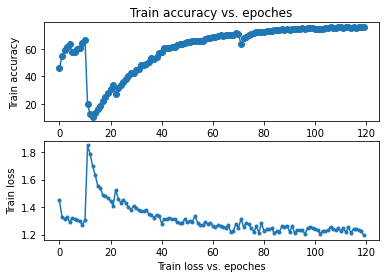

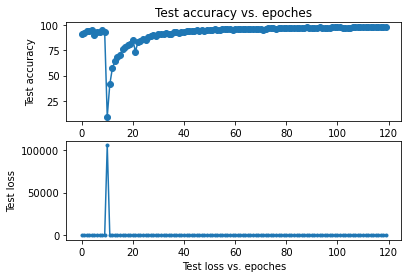

<Figure size 432x288 with 0 Axes>

In [32]:
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.5)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=120)

In [322]:
model = torch.load("45_kd_sar-teacher_eo-student_pretrain-on-sar/resnet34_kd114.pt")

import pandas as pd
from torch.utils import data
from tqdm import tqdm
from PIL import Image
class ImageData(data.Dataset):
    def __init__(self,df,dirpath,transform,test = False):
        self.df = df
        self.test = test
        self.dirpath = dirpath
        self.conv_to_tensor = transform
        #image data 
        if not self.test:
            self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0]+'.png')
        else:
            self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0])
        
        #labels data
        if not self.test:
             self.label_df = self.df.iloc[:,1]
        
        # Calculate length of df
        self.data_len = len(self.df.index)

    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        image_name = self.image_arr[idx]
        img = Image.open(image_name)#.convert('RGB')
        img_tensor = self.conv_to_tensor(img)
        if not self.test:
            image_labels = self.label_df[idx]
            label_tensor = torch.zeros((1, output_dim))
            for label in image_labels.split():
                label_tensor[0, int(label)] = 1
            image_label = torch.tensor(label_tensor,dtype= torch.float32)
            return (img_tensor,image_label.squeeze())
        return (img_tensor)

    
BATCH_SIZE = 1
test_dir = "./test"
test_dir_ls = os.listdir(test_dir)
test_dir_ls.sort()
test_df = pd.DataFrame(test_dir_ls)

test_dataset = ImageData(test_df,test_dir,EO_data_transforms["valid_EO"],test = True)
test_loader = data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False)

output_dim = 10

DISABLE_TQDM = False
predictions = np.zeros((len(test_dataset), output_dim))
i = 0
for test_batch in tqdm(test_loader,disable = DISABLE_TQDM):
    test_batch = test_batch.to(device)
    batch_prediction = model(test_batch).detach().cpu().numpy()
    predictions[i * BATCH_SIZE:(i+1) * BATCH_SIZE, :] = batch_prediction
    i+=1
    


100%|██████████| 826/826 [00:13<00:00, 60.65it/s]


In [323]:
predictions[170]

array([ 0.58270353,  0.30629265, -0.13955797,  0.03628556, -0.2149303 ,
       -0.11002927, -0.2283311 ,  0.14948022, -0.26729292, -0.18283895])

In [343]:
pred = np.argmax(predictions,axis = 1)
pred_list = []
for i in range(len(pred)):
    result = [pred[i]]
    pred_list.append(result)
pred_list



[[2],
 [1],
 [0],
 [0],
 [5],
 [5],
 [4],
 [5],
 [1],
 [8],
 [1],
 [0],
 [0],
 [3],
 [5],
 [5],
 [0],
 [3],
 [4],
 [3],
 [8],
 [4],
 [3],
 [2],
 [0],
 [3],
 [3],
 [0],
 [4],
 [2],
 [5],
 [3],
 [1],
 [4],
 [5],
 [5],
 [6],
 [7],
 [5],
 [2],
 [7],
 [5],
 [3],
 [5],
 [0],
 [0],
 [0],
 [5],
 [0],
 [3],
 [2],
 [0],
 [5],
 [0],
 [4],
 [5],
 [7],
 [2],
 [5],
 [5],
 [1],
 [7],
 [2],
 [2],
 [1],
 [2],
 [1],
 [4],
 [0],
 [0],
 [7],
 [1],
 [6],
 [1],
 [2],
 [4],
 [4],
 [1],
 [0],
 [6],
 [4],
 [0],
 [1],
 [3],
 [5],
 [4],
 [4],
 [4],
 [0],
 [4],
 [5],
 [5],
 [5],
 [5],
 [6],
 [5],
 [6],
 [4],
 [5],
 [7],
 [0],
 [0],
 [0],
 [0],
 [2],
 [2],
 [5],
 [2],
 [1],
 [4],
 [2],
 [0],
 [3],
 [4],
 [4],
 [3],
 [2],
 [3],
 [5],
 [4],
 [5],
 [8],
 [4],
 [0],
 [4],
 [0],
 [1],
 [1],
 [5],
 [5],
 [4],
 [5],
 [0],
 [3],
 [0],
 [1],
 [0],
 [0],
 [4],
 [0],
 [1],
 [0],
 [3],
 [1],
 [0],
 [3],
 [2],
 [4],
 [4],
 [1],
 [6],
 [5],
 [5],
 [1],
 [0],
 [5],
 [5],
 [9],
 [0],
 [6],
 [4],
 [1],
 [3],
 [4],
 [3],
 [4],
 [4]

In [344]:
predicted_class_idx = pred_list

test_df['class_id'] = predicted_class_idx
test_df['class_id'] = test_df['class_id'].apply(lambda x : ' '.join(map(str,list(x))))
test_df = test_df.rename(columns={0: 'image_id'})
test_df['image_id'] = test_df['image_id'].apply(lambda x : x.split('.')[0])
test_df


image_id class_id
0    EO_100578        2
1     EO_10079        1
2    EO_102385        0
3     EO_10264        0
4    EO_103494        5
..         ...      ...
821   EO_93885        7
822   EO_95890        1
823   EO_96662        5
824   EO_97302        4
825   EO_99431        6

[826 rows x 2 columns]

In [345]:
for (idx, row) in test_df.iterrows():
    row.image_id = row.image_id.split("_")[1]


In [346]:
for k in range(10):
    i = 0
    for (idx, row) in test_df.iterrows():
        if row.class_id == str(k):
            i+=1
    print(i)

113
103
95
85
132
135
21
119
18
5


In [295]:
test_df

image_id class_id
0     100578        2
1      10079        1
2     102385        0
3      10264        0
4     103494        5
..       ...      ...
821    93885        7
822    95890        1
823    96662        5
824    97302        4
825    99431        6

[826 rows x 2 columns]

In [296]:
test_df.to_csv('results.csv',index = False)